In [ ]:
import pandas as pd
import os
import shutil
import pickle

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
import numpy as np
import cv2 as cv
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from google.colab import drive
#drive.mount('/content/gdrive')

Using TensorFlow backend.


In [ ]:
# To get reproducible results 
np.random.seed(1234)
tf.random.set_seed(1234)

Emotion labels in the dataset:
0: -4593 images- Angry
1: -547 images- Disgust
2: -5121 images- Fear
3: -8989 images- Happy
4: -6077 images- Sad
5: -4002 images- Surprise
6: -6198 images- Neutral

In [ ]:
if not os.path.exists('fer2013'):
  print("Directory doesn't exist yet. Downloading...")
  !wget -O fer2013.zip "https://cpslo-my.sharepoint.com/:u:/g/personal/lepopal_calpoly_edu/EY30dmi8r1hIi2lkujtWktABxubs0t3Bu2tJuhHKGp7GSA?e=6doqTw&download=1"
  !unzip fer2013*
  print("Done!")
  fer = pd.read_csv('fer2013.csv')
else:
  print("Directory exists. Loading into pandas...")
  fer = pd.read_csv('fer2013.csv')

Directory doesn't exist yet. Downloading...
--2020-06-02 23:14:46--  https://cpslo-my.sharepoint.com/:u:/g/personal/lepopal_calpoly_edu/EY30dmi8r1hIi2lkujtWktABxubs0t3Bu2tJuhHKGp7GSA?e=6doqTw&download=1
Resolving cpslo-my.sharepoint.com (cpslo-my.sharepoint.com)... 13.107.136.9
Connecting to cpslo-my.sharepoint.com (cpslo-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/lepopal_calpoly_edu/Documents/cpe428/fer2013.zip?&originalPath=aHR0cHM6Ly9jcHNsby1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9sZXBvcGFsX2NhbHBvbHlfZWR1L0VZMzBkbWk4cjFoSWkybGt1anRXa3RBQnh1YnMwdDNCdTJ0SnVoSEtHcDdHU0E_cnRpbWU9eVprUXZrb0gyRWc [following]
--2020-06-02 23:14:47--  https://cpslo-my.sharepoint.com/personal/lepopal_calpoly_edu/Documents/cpe428/fer2013.zip?&originalPath=aHR0cHM6Ly9jcHNsby1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9sZXBvcGFsX2NhbHBvbHlfZWR1L0VZMzBkbWk4cjFoSWkybGt1anRXa3RBQnh1YnMwdDNCdTJ0SnVoSEtHcDdHU0E_cnRpbWU9eVprUXZrb0gyRWc

In [ ]:
if not os.path.exists('EmotionRecognition.zip'):
  !wget -O EmotionRecognition.zip "https://cpslo-my.sharepoint.com/:u:/g/personal/lepopal_calpoly_edu/EZ0ZMfOieu9At5CW9I9qD1EBTM6P4FIZWecaiTyQvK-j3Q?e=2GDa5p&download=1"
  !unzip EmotionRecognition*
  print("Done")
else:
  print("Already exists")

--2020-06-02 23:19:12--  https://cpslo-my.sharepoint.com/:u:/g/personal/lepopal_calpoly_edu/EZ0ZMfOieu9At5CW9I9qD1EBTM6P4FIZWecaiTyQvK-j3Q?e=2GDa5p&download=1
Resolving cpslo-my.sharepoint.com (cpslo-my.sharepoint.com)... 13.107.136.9
Connecting to cpslo-my.sharepoint.com (cpslo-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/lepopal_calpoly_edu/Documents/cpe428/EmotionRecognition.zip?&originalPath=aHR0cHM6Ly9jcHNsby1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9sZXBvcGFsX2NhbHBvbHlfZWR1L0VaMFpNZk9pZXU5QXQ1Q1c5STlxRDFFQlRNNlA0RklaV2VjYWlUeVF2Sy1qM1E_cnRpbWU9NzVxVVhFc0gyRWc [following]
--2020-06-02 23:19:12--  https://cpslo-my.sharepoint.com/personal/lepopal_calpoly_edu/Documents/cpe428/EmotionRecognition.zip?&originalPath=aHR0cHM6Ly9jcHNsby1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9sZXBvcGFsX2NhbHBvbHlfZWR1L0VaMFpNZk9pZXU5QXQ1Q1c5STlxRDFFQlRNNlA0RklaV2VjYWlUeVF2Sy1qM1E_cnRpbWU9NzVxVVhFc0gyRWc
Reusing existing conn

In [ ]:
fer.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
"""
Creates directory structure. 

fer2013
  train
    angry
    disgust
    fear
    happy
    sad
    surprise
    neutral
  validation
    angry
    disgust
    fear
    happy
    sad
    surprise
    neutral
  test
    angry
    disgust
    fear
    happy
    sad
    surprise
    neutral
"""

def save_fer_image(df):
  emotions_exclude = [1] # don't include disgust emotion
  emotions = {0:"angry", 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 
              5:'surprise', 6:'neutral'}
  usages = {'train':'Training', 'validation':'PublicTest', 'test':'PrivateTest'}

  # if folder exists, delete it 
  if os.path.exists('fer2013'):
    shutil.rmtree('fer2013')
    os.mkdir('fer2013')
  else:
    os.mkdir('fer2013')

  for category in ['train', 'validation', 'test']:
    path_name_cat = 'fer2013/' + category
    if not os.path.exists(path_name_cat):
      os.mkdir(path_name_cat)

    emotions_list = list(df['emotion'].unique()) # remove emotions we don't want
    for e in emotions_exclude:
      emotions_list.remove(e)
    
    for emotion in emotions_list:
      emotion_str = emotions[emotion]
      path_name_emotion = os.path.join(path_name_cat, emotion_str)

      if not os.path.exists(path_name_emotion):
        os.mkdir(path_name_emotion)

      for index,row in df[(df['emotion'] == emotion) & (df['Usage'] == usages[category])].iterrows():
        pixels = np.asarray(list(row['pixels'].split(" ")), dtype=np.uint8) # divide by 255 to get floats?
        img = pixels.reshape((48,48))
        file_name = os.path.join(path_name_emotion, str(index) + '.jpg')
        cv.imwrite(file_name, img)

In [ ]:
save_fer_image(fer)

Show the first 3 images for each emotion in train folder.

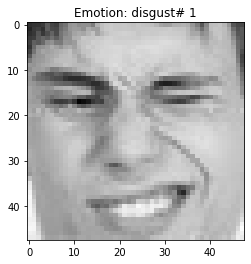

fer2013/train/disgust/18464.jpg


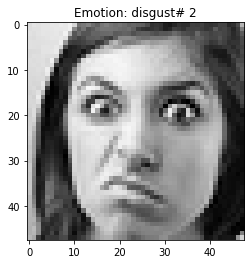

fer2013/train/disgust/15287.jpg


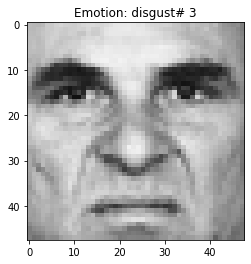

fer2013/train/disgust/12003.jpg


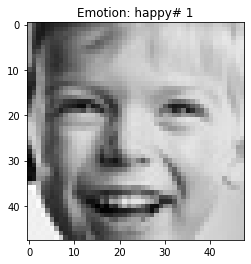

fer2013/train/happy/17673.jpg


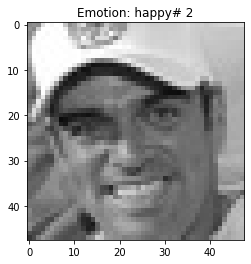

fer2013/train/happy/1570.jpg


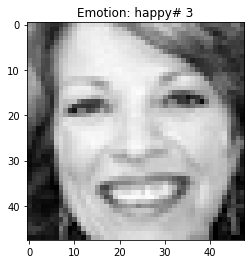

fer2013/train/happy/18493.jpg


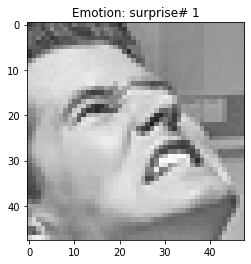

fer2013/train/surprise/19231.jpg


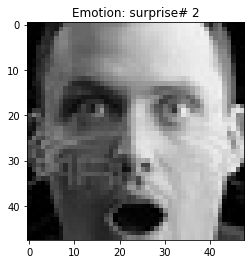

fer2013/train/surprise/9859.jpg


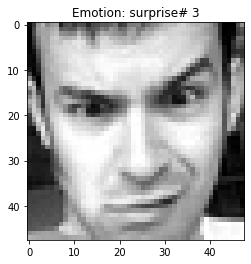

fer2013/train/surprise/4066.jpg


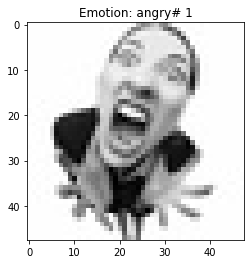

fer2013/train/angry/7015.jpg


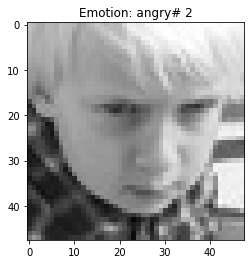

fer2013/train/angry/14381.jpg


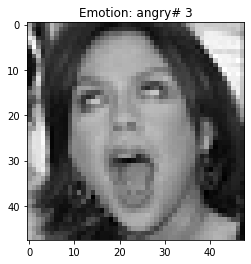

fer2013/train/angry/13550.jpg


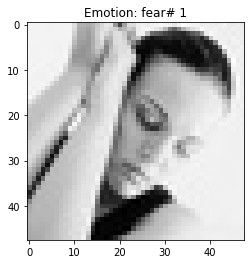

fer2013/train/fear/13798.jpg


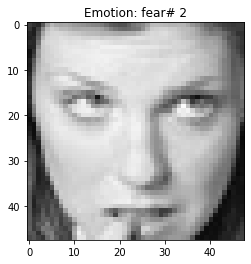

fer2013/train/fear/15421.jpg


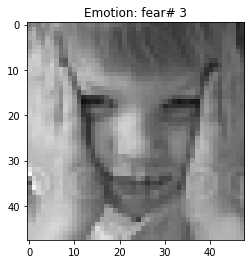

fer2013/train/fear/25464.jpg


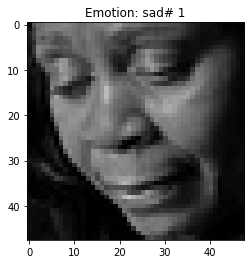

fer2013/train/sad/23882.jpg


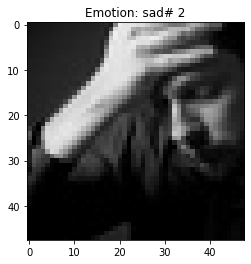

fer2013/train/sad/24191.jpg


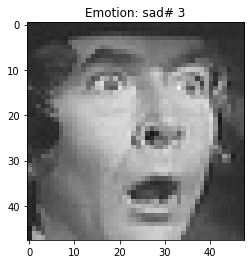

fer2013/train/sad/14122.jpg


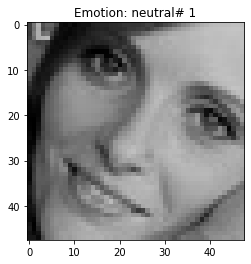

fer2013/train/neutral/10654.jpg


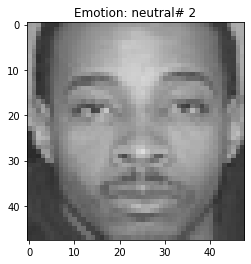

fer2013/train/neutral/22415.jpg


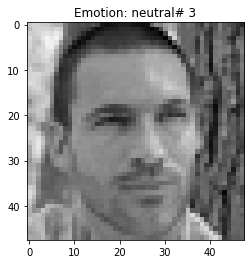

fer2013/train/neutral/5157.jpg


In [ ]:
folder = 'fer2013/train'
for emotion in os.listdir(folder):
  path_name = os.path.join(folder, emotion)
  count = 1
  for img_name in os.listdir(path_name)[:3]:
    file_name = os.path.join(path_name, img_name)
    img = cv.imread(file_name)
    plt.title("Emotion: " + str(emotion) + "# " + str(count))
    plt.imshow((np.squeeze(img)).astype('uint8'), cmap='Greys')
    plt.show()
    count += 1
    print(file_name)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

test_data_dir = 'fer2013/test'
img_width, img_height = 48, 48
batch_size = 128

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', # categorical
    shuffle=False) 

Found 3589 images belonging to 7 classes.


Load the best model so far.

In [ ]:
model = keras.models.load_model('weights-improvement-24-0.66.hdf5')

In [ ]:
# history doesn't work on saved model?
model.history

In [ ]:
model.evaluate_generator(test_generator)

[1.9635404348373413, 0.6815268993377686]

In [ ]:
# From https://stackoverflow.com/questions/52270177/how-to-use-predict-generator-on-new-images-keras
test_generator.reset()

# file names used for prediction
filenames = test_generator.filenames

# returns a dict {'angry': 0, ...}
labels = test_generator.class_indices

# swap key and value {0: 'angry', ...}
labels = dict((v,k) for k,v in labels.items())

In [ ]:
print(labels)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [ ]:
preds = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

29/29 [==============================] - 1s 37ms/step


In [ ]:
print(preds[0])
print(filenames[0])

[6.2407184e-01 2.8637779e-01 1.5812840e-02 8.6475084e-06 5.7509594e-04
 6.4580273e-03 6.6695824e-02]
angry/32298.jpg


In [ ]:
predicted_class_indices = np.argmax(preds, axis=1)
predicted_class_indices

array([0, 0, 0, ..., 4, 6, 6])

In [ ]:
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
results = pd.DataFrame({"Filename": filenames, "Predictions":predictions})

In [ ]:
results.head()

,Filename,Predictions
0,angry/32298.jpg,angry
1,angry/32303.jpg,angry
2,angry/32306.jpg,angry
3,angry/32312.jpg,sad
4,angry/32320.jpg,angry


In [ ]:
(results["Filename"].str.split("/").apply(lambda x: x[0]) == results["Predictions"]).value_counts()

True     2446
False    1143
dtype: int64

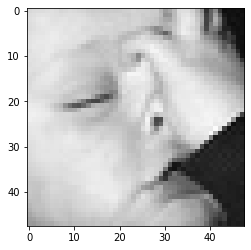

In [ ]:
# test
img = cv.imread('fer2013/test/angry/32312.jpg')
plt.imshow(img)
plt.show()